In [1]:
import pandas as pd
import json
import os
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import torch
import numpy as np
import pickle
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_reddit_data(file_paths):
    all_data = []
    
    for file_path in file_paths:
        with open(file_path, 'r', encoding='utf-8') as f:
            file_data = [json.loads(line) for line in f]
            all_data.extend(file_data)
    
    df = pd.DataFrame(all_data)
    

    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    
    if df['date'].isna().any():
        print(f"Warning: {df['date'].isna().sum()} rows had invalid date formats and were dropped")
        df = df.dropna(subset=['date'])
    
    return df

In [3]:
def load_cointelegraph_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.loads(f.read())
    
    df = pd.DataFrame(data)
    
    df['published_time'] = pd.to_datetime(df['published_time'])
    
    return df

In [4]:
def load_bitcoinmagazine_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.loads(f.read())
    
    df = pd.DataFrame(data)
    
    df['published_time'] = pd.to_datetime(df['published_time'])
    
    return df

In [5]:
def load_twitter_data(file_path):
    df = pd.read_csv(file_path)
    
    if 'date' in df.columns and 'time' in df.columns:
        df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    
    return df

In [6]:
def get_embeddings(texts, dates, model, task='Analyze sentiment and key information about Bitcoin in this text', batch_size=32):
    results = []
    
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        batch_dates = dates[i:i+batch_size]
        
        instructed_texts = [f'Instruct: {task}\nQuery: {text}' for text in batch_texts]
        
        with torch.no_grad():
            embeddings = model.encode(instructed_texts, convert_to_tensor=True, normalize_embeddings=True)
            embeddings_np = embeddings.cpu().numpy()
        
        for j in range(len(batch_texts)):
            results.append({
                'date': batch_dates[j],
                'embedding': embeddings_np[j]
            })
    
    return results

In [7]:
def process_news_df1(df, model):
    texts = []
    for _, row in df.iterrows():
        combined_text = f"{row['title']} - {row['text']}"
        texts.append(combined_text)
    
    dates = df['published_time'].tolist()
    return get_embeddings(texts, dates, model)

In [8]:
def process_news_df2(df, model):
    texts = []
    for _, row in df.iterrows():
        combined_text = f"{row['title']} - {row['text']}"
        texts.append(combined_text)
    
    dates = df['published_time'].tolist()
    return get_embeddings(texts, dates, model)

In [9]:
def process_tweets(df, model):
    texts = df['content'].tolist()
    
    if 'datetime' in df.columns:
        dates = df['datetime'].tolist()
    else:
        dates = pd.to_datetime(df['date'] + ' ' + df['time']).tolist()
        
    return get_embeddings(texts, dates, model)

In [10]:
def process_reddit(df, model):
    texts = []
    for _, row in df.iterrows():
        post_text = f"Title: {row['title']}\nContent: {row['text']}"
        
        if isinstance(row['comments'], list) and len(row['comments']) > 0:
            comments_text = "\nComments: " + " | ".join(row['comments'][:3])
            post_text += comments_text
            
        texts.append(post_text)
    
    dates = df['date'].tolist()
    return get_embeddings(texts, dates, model)

In [11]:
def main(reddit_file_paths, twitter_file_path, cointelegraph_file_path, bitcoinmagazine_file_path):
    model = SentenceTransformer('intfloat/multilingual-e5-large-instruct', device=torch.device('cuda:0'))
    
    print("Loading Reddit data...")
    df4 = load_reddit_data(reddit_file_paths)
    
    print("Loading Twitter data...")
    df3 = load_twitter_data(twitter_file_path)
    
    print("Loading CoinTelegraph news...")
    df1 = load_cointelegraph_data(cointelegraph_file_path)
    
    print("Loading BitcoinMagazine news...")
    df2 = load_bitcoinmagazine_data(bitcoinmagazine_file_path)
    
    print("Generating embeddings for CoinTelegraph news...")
    news1_embeddings = process_news_df1(df1, model)
    with open('news1_embeddings.pkl', 'wb') as f:
        pickle.dump(news1_embeddings, f)
    
    print("Generating embeddings for BitcoinMagazine news...")
    news2_embeddings = process_news_df2(df2, model)
    with open('news2_embeddings.pkl', 'wb') as f:
        pickle.dump(news2_embeddings, f)
    
    print("Generating embeddings for Tweets...")
    tweets_embeddings = process_tweets(df3, model)
    with open('tweets_embeddings.pkl', 'wb') as f:
        pickle.dump(tweets_embeddings, f)
    
    #print("Generating embeddings for Reddit posts...")
    #reddit_embeddings = process_reddit(df4, model)  
    
    #with open('reddit_embeddings.pkl', 'wb') as f:
    #    pickle.dump(reddit_embeddings, f)
    
    print("All embeddings have been generated and saved!")
    
    return df1, df2, df3    #, df4

#редит не стал обрабатывать так как до меня не совсем правильные данные дошли
#мы пофиксим это, и позже дообработаем 

In [12]:
reddit_file_paths = ['/kaggle/input/2-stage-data/2025-03-02-10-53-58.json', '/kaggle/input/2-stage-data/2025-03-02-18-07-41.json', '/kaggle/input/2-stage-data/2025-03-12-22-18-35.json']
twitter_file_path = '/kaggle/input/2-stage-data/tweets.csv'
cointelegraph_file_path = '/kaggle/input/2-stage-data/CoinTelegraph_Articles.json'
bitcoinmagazine_file_path = '/kaggle/input/2-stage-data/BitcoinMagazine_Articles.json'

#df4 = load_reddit_data(reddit_file_paths)  
df3 = load_twitter_data(twitter_file_path) 
df1 = load_cointelegraph_data(cointelegraph_file_path)
df2 = load_bitcoinmagazine_data(bitcoinmagazine_file_path)

<ipython-input-3-9da73ca2993f>:7: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['published_time'] = pd.to_datetime(df['published_time'])


In [13]:
pd.set_option('display.float_format', '{:.0f}'.format)

#### 

In [14]:
df1.describe(include='all')

,title,url,published_time,views,text
count,27158,27158,27158,27158,27158
unique,27158,27158,27111,NaN,26979
top,Bitcoin exchange Mt.Gox reveals technical upgr...,https://cointelegraph.com/news/bitcoin_exchang...,2017-08-17 21:00:00+01:00,NaN,
freq,1,1,3,NaN,180
mean,NaN,NaN,NaN,15301,NaN
std,NaN,NaN,NaN,20842,NaN
min,NaN,NaN,NaN,0,NaN
25%,NaN,NaN,NaN,4918,NaN
50%,NaN,NaN,NaN,9486,NaN
75%,NaN,NaN,NaN,18579,NaN


In [15]:
missing_values = df1.isnull().sum()
missing_percentage = (df1.isnull().sum() / len(df1)) * 100
missing_data = pd.concat([missing_values, missing_percentage], axis=1)
missing_data.columns = ['Missing Values', 'Percentage']
print(missing_data)

                Missing Values  Percentage
title                        0           0
url                          0           0
published_time               0           0
views                        0           0
text                         0           0


In [16]:
def check_data_validity(df):

    problems = {}
    
    problems['empty_titles'] = (df['title'].str.len() <= 0).sum()
    problems['empty_text'] = (df['text'].str.len() <= 0).sum()
    
    problems['negative_views'] = (df['views'] < 0).sum()
    
    problems['invalid_urls'] = (~df['url'].str.startswith(('http://', 'https://'))).sum()
    
    try:
        if not pd.api.types.is_datetime64_any_dtype(df['published_time']):
            pd.to_datetime(df['published_time'], utc=True)
        problems['invalid_dates'] = 0
    except Exception as e:
        problems['invalid_dates'] = f"Ошибка: {str(e)}"
    
    problems['duplicate_urls'] = df.duplicated(subset=['url']).sum()
    problems['duplicate_titles'] = df.duplicated(subset=['title']).sum()
    problems['duplicate_texts'] = df.duplicated(subset=['text']).sum()
    
    return problems


validity_issues = check_data_validity(df1)
print("Проблемы с валидностью данных:")
for issue, count in validity_issues.items():
    print(f"- {issue}: {count}")

l = len(df1)
print(f"Количество строк до удаления: {l}")

df1 = df1[df1['text'].str.len() > 0]
df1 = df1.drop_duplicates(subset=['title'], keep='first')
df1 = df1.drop_duplicates(subset=['text'], keep='first')

print(f"Количество строк после удаления: {len(df1)}")
print(f"Удалено строк: {l - len(df1)}")

Проблемы с валидностью данных:
- empty_titles: 0
- empty_text: 180
- negative_views: 0
- invalid_urls: 0
- invalid_dates: 0
- duplicate_urls: 0
- duplicate_titles: 0
- duplicate_texts: 179
Количество строк до удаления: 27158
Количество строк после удаления: 26978
Удалено строк: 180


In [17]:
if 'title_length' not in df1.columns:
    df1['title_length'] = df1['title'].apply(len)
if 'text_length' not in df1.columns:
    df1['text_length'] = df1['text'].apply(len)

columns_to_check = ['views', 'title_length', 'text_length']

for column in columns_to_check:
    Q1 = df1[column].quantile(0.25)
    Q3 = df1[column].quantile(0.75)
    IQR = Q3 - Q1
    
    theoretical_lower = Q1 - 1.5 * IQR
    theoretical_upper = Q3 + 1.5 * IQR
    
    if column == 'title_length':
        lower_bound = max(20, theoretical_lower)
    elif column == 'text_length':
        lower_bound = max(80, theoretical_lower)
    else:
        lower_bound = max(0, theoretical_lower)
    
    
    upper_bound = theoretical_upper
    
    outliers = df1[(df1[column] < lower_bound) | (df1[column] > upper_bound)]
    outliers_count = len(outliers)
    outliers_percentage = (outliers_count / len(df1)) * 100
    
    print(f"\n--- Анализ выбросов для столбца '{column}' ---")
    print(f"Теоретическая нижняя граница: {theoretical_lower:.2f}")
    print(f"Скорректированная нижняя граница: {lower_bound:.2f}")
    print(f"Верхняя граница: {upper_bound:.2f}")
    print(f"Количество выбросов: {outliers_count} ({outliers_percentage:.2f}%)")
    
    if outliers_count > 0:
        print("\nПримеры выбросов:")
        if column == 'views':
            print("\nНаибольшие значения:")
            print(df1.nlargest(5, column)[['title', column]])
            
            if lower_bound > 0:
                print("\nНаименьшие значения:")
                print(df1.nsmallest(5, column)[['title', column]])
        
        elif column == 'title_length':
            print("\nСамые длинные заголовки:")
            longest_titles = df1.nlargest(5, column)
            print(longest_titles[['title', column]])
            
            print("\nСамые короткие заголовки:")
            shortest_titles = df1.nsmallest(5, column)
            print(shortest_titles[['title', column]])
        
        elif column == 'text_length':
            print("\nСамые длинные тексты (первые 50 символов):")
            longest_texts = df1.nlargest(5, column)
            for idx, row in longest_texts.iterrows():
                print(f"{row['text_length']} символов: {row['text'][:50]}...")
            
            print("\nСамые короткие тексты:")
            shortest_texts = df1.nsmallest(5, column)
            for idx, row in shortest_texts.iterrows():
                print(f"{row['text_length']} символов: {row['text']}")
    
    if column == 'views':
        df1[f'{column}_capped'] = df1[column].clip(upper=upper_bound)
    elif column in ['title_length', 'text_length']:
        df1[f'{column}_is_outlier'] = ((df1[column] < lower_bound) | (df1[column] > upper_bound)).astype(int)

outlier_mask = np.zeros(len(df1), dtype=bool)
for column in columns_to_check:
    Q1 = df1[column].quantile(0.25)
    Q3 = df1[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    column_outliers = (df1[column] < lower_bound) | (df1[column] > upper_bound)
    outlier_mask = outlier_mask | column_outliers
l = len(df1)
df1 = df1[~outlier_mask]
print(f"\nОбщее количество строк без выбросов: {len(df1)} из {l} ({len(df1)/l*100:.2f}%)")


--- Анализ выбросов для столбца 'views' ---
Теоретическая нижняя граница: -15526.00
Скорректированная нижняя граница: 0.00
Верхняя граница: 39168.00
Количество выбросов: 2083 (7.72%)

Примеры выбросов:

Наибольшие значения:
                                                   title    views
1527   Binance, CZ file motion to dismiss SEC’s amend...  1270893
2020   Fed’s ‘juice’ into crypto has analyst eyeing ‘...   565347
22431  Bitcoin, Ethereum, Bitcoin Cash, Ripple, IOTA,...   416717
22232  Bitcoin, Ethereum, Bitcoin Cash, Ripple, Stell...   361472
22298  Bitcoin, Ethereum, Bitcoin Cash, Ripple, IOTA,...   359738

--- Анализ выбросов для столбца 'title_length' ---
Теоретическая нижняя граница: 44.00
Скорректированная нижняя граница: 44.00
Верхняя граница: 92.00
Количество выбросов: 1491 (5.53%)

Примеры выбросов:

Самые длинные заголовки:
                                                   title  title_length
21448  Hodler’s Digest, July 9-15: While Mining ETH i...           143
25772  

year
2013     149
2014     636
2015     444
2016     712
2017    1414
2018    1037
2019    2110
2020    2834
2021    2657
2022    2439
2023    2212
2024    3437
2025     668
Name: count, dtype: int64


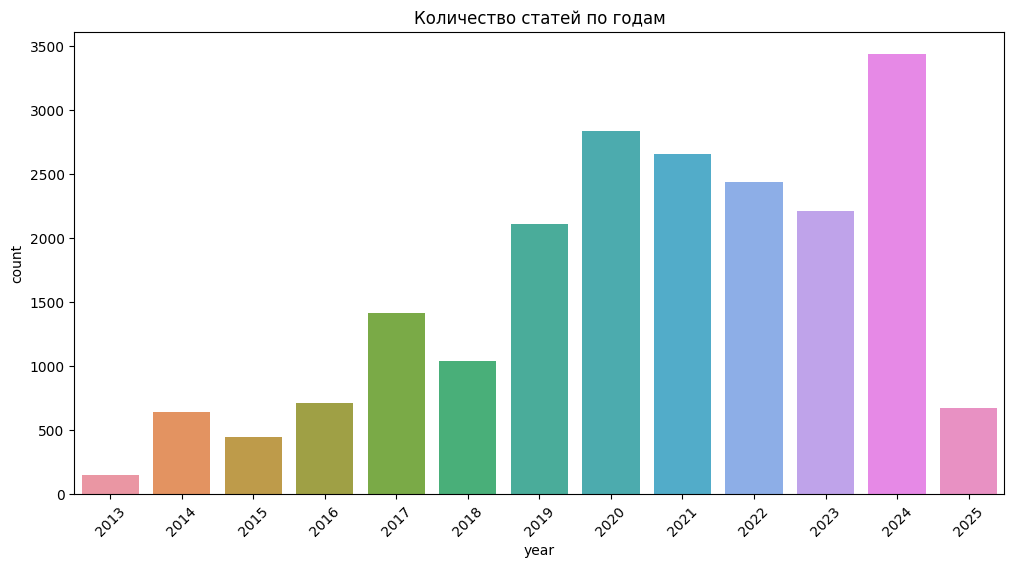

In [18]:
df1['published_time'] = pd.to_datetime(df1['published_time'], utc=True)

df1['year'] = df1['published_time'].dt.year
df1['month'] = df1['published_time'].dt.month
df1['day'] = df1['published_time'].dt.day
df1['day_of_week'] = df1['published_time'].dt.dayofweek
df1['hour'] = df1['published_time'].dt.hour

yearly_articles = df1['year'].value_counts().sort_index()
print(yearly_articles)

plt.figure(figsize=(12, 6))
sns.countplot(data=df1, x='year', order=sorted(df1['year'].unique()))
plt.title('Количество статей по годам')
plt.xticks(rotation=45)
plt.show()

       title_length  text_length
count         20749        20749
mean             68         2865
std              10         1046
min              44           72
25%              63         2177
50%              69         2634
75%              74         3255
max              92         6573


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


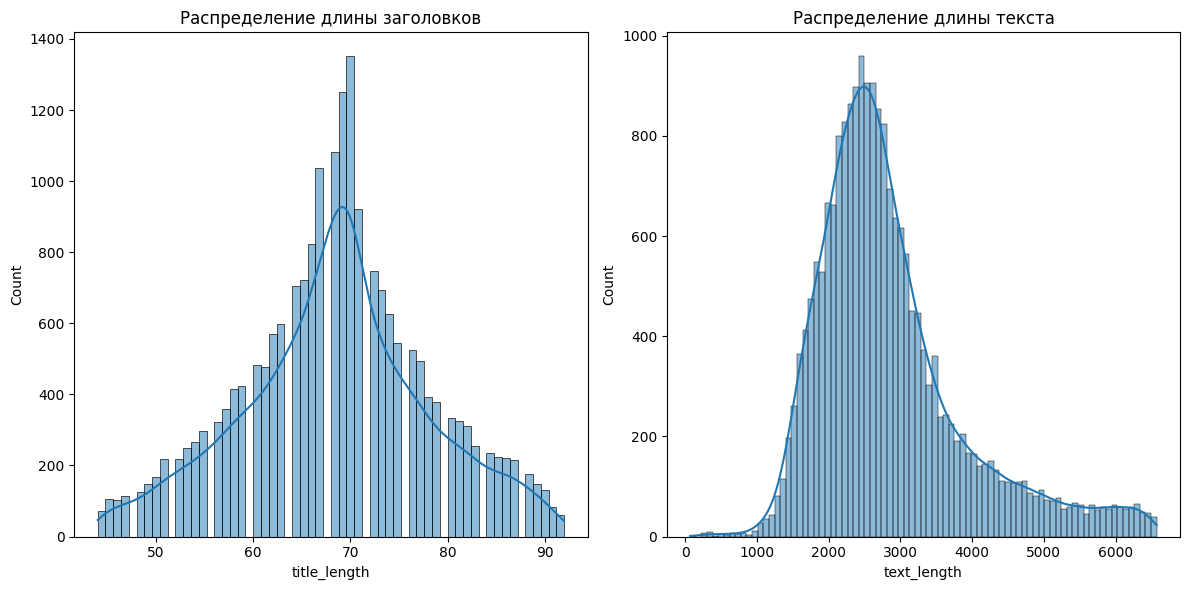

Самые популярные слова в заголовках:
[('bitcoin', 13610), ('crypto', 4082), ('price', 3447), ('btc', 2797), ('for', 2718), ('the', 2580), ('and', 1775), ('new', 1227), ('with', 1166), ('says', 1073), ('market', 951), ('after', 787), ('exchange', 780), ('will', 753), ('etf', 725), ('mining', 706), ('from', 687), ('trading', 560), ('report', 547), ('traders', 542)]


In [19]:
df1['title_length'] = df1['title'].apply(len)
df1['text_length'] = df1['text'].apply(len)

print(df1[['title_length', 'text_length']].describe())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df1['title_length'], kde=True)
plt.title('Распределение длины заголовков')

plt.subplot(1, 2, 2)
sns.histplot(df1['text_length'], kde=True)
plt.title('Распределение длины текста')
plt.tight_layout()
plt.show()

from collections import Counter
import re

def get_top_words(text_series, n=20):
    all_text = ' '.join(text_series.astype(str))
    words = re.findall(r'\b[a-zA-Z]{3,}\b', all_text.lower())
    return Counter(words).most_common(n)

top_title_words = get_top_words(df1['title'], 20)
print("Самые популярные слова в заголовках:")
print(top_title_words)

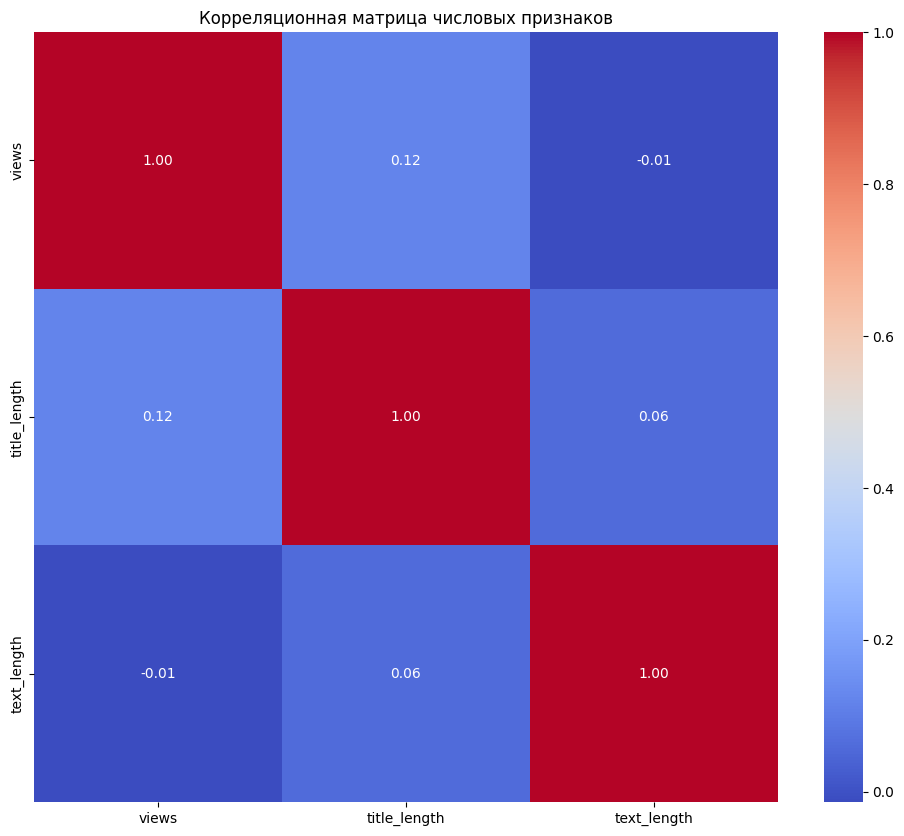

In [20]:
numeric_df = df1[['views', 'title_length', 'text_length']]
correlation = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица числовых признаков')
plt.show()

<ipython-input-21-f8a3fa8777b4>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df1['year_month'] = df1['published_time'].dt.to_period('M')


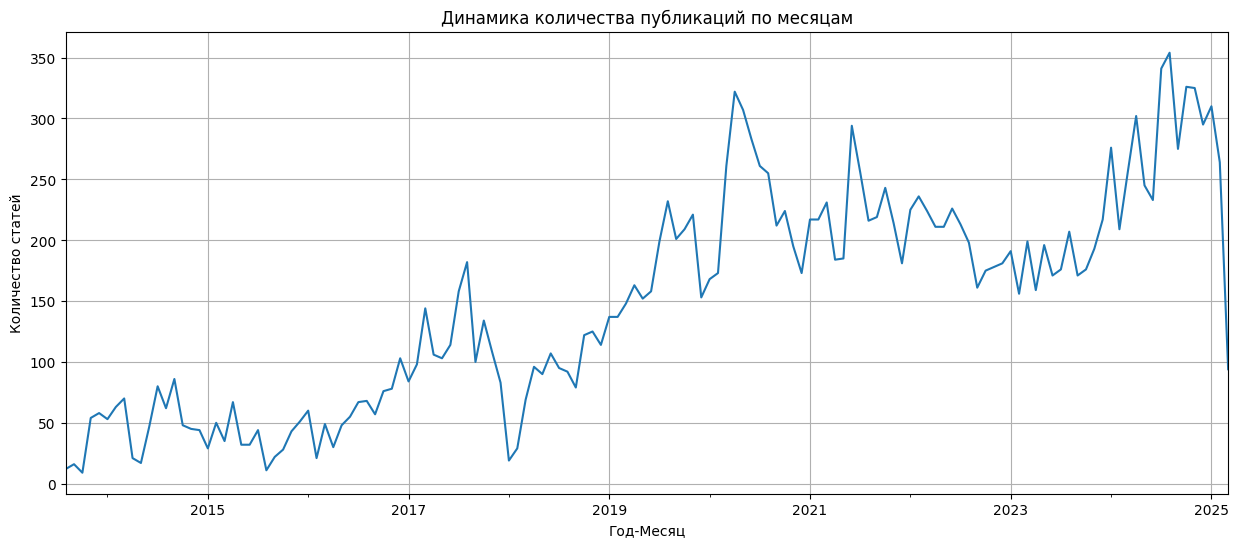

In [21]:
df1['year_month'] = df1['published_time'].dt.to_period('M')
monthly_articles = df1.groupby('year_month').size()

plt.figure(figsize=(15, 6))
monthly_articles.plot()
plt.title('Динамика количества публикаций по месяцам')
plt.xlabel('Год-Месяц')
plt.ylabel('Количество статей')
plt.grid(True)
plt.show()

In [22]:
df2.describe(include='all')

,title,url,published_time,text
count,12262,12262,12262,12262
unique,12206,12262,NaN,12115
top,PwC Report: Cryptocurrency Represents The Begi...,https://bitcoinmagazine.com/business/the-waste...,NaN,
freq,2,1,NaN,55
mean,NaN,NaN,2020-03-01 01:51:19.408008448-05:00,NaN
min,NaN,NaN,2012-02-28 06:06:16-05:00,NaN
25%,NaN,NaN,2017-09-04 18:03:53.500000-05:00,NaN
50%,NaN,NaN,2021-05-12 20:38:04-05:00,NaN
75%,NaN,NaN,2022-08-11 01:07:30-05:00,NaN
max,NaN,NaN,2025-03-07 21:38:56-05:00,NaN


In [23]:
missing_values = df2.isnull().sum()
missing_percentage = (df2.isnull().sum() / len(df2)) * 100
missing_data = pd.concat([missing_values, missing_percentage], axis=1)
missing_data.columns = ['Missing Values', 'Percentage']
print(missing_data)
df2 = df2.dropna(subset=['title', 'url', 'published_time', 'text'])
missing_values = df2.isna().sum()
missing_percentage = (df2.isnull().sum() / len(df2)) * 100
missing_data = pd.concat([missing_values, missing_percentage], axis=1)
missing_data.columns = ['Missing Values', 'Percentage']
print(missing_data)

                Missing Values  Percentage
title                        7           0
url                          7           0
published_time               7           0
text                         7           0
                Missing Values  Percentage
title                        0           0
url                          0           0
published_time               0           0
text                         0           0


In [24]:
def check_data_validity(df):

    problems = {}
    
    problems['empty_titles'] = (df['title'].str.len() <= 0).sum()
    problems['empty_text'] = (df['text'].str.len() <= 0).sum()
    
    #problems['negative_views'] = (df['views'] < 0).sum()
    
    problems['invalid_urls'] = (~df['url'].str.startswith(('http://', 'https://'))).sum()
    
    try:
        if not pd.api.types.is_datetime64_any_dtype(df['published_time']):
            pd.to_datetime(df['published_time'])
        problems['invalid_dates'] = 0
    except Exception as e:
        problems['invalid_dates'] = f"Ошибка: {str(e)}"
    
    problems['duplicate_urls'] = df.duplicated(subset=['url']).sum()
    problems['duplicate_titles'] = df.duplicated(subset=['title']).sum()
    problems['duplicate_texts'] = df.duplicated(subset=['text']).sum()
    
    return problems


validity_issues = check_data_validity(df2)
print("Проблемы с валидностью данных:")
for issue, count in validity_issues.items():
    print(f"- {issue}: {count}")

l = len(df2)
print(f"Количество строк до удаления: {l}")

df2 = df2[df2['text'].str.len() > 0]
df2 = df2.drop_duplicates(subset=['title', 'text'])
df2 = df2.drop_duplicates(subset=['title'], keep='first')
df2 = df2.drop_duplicates(subset=['text'], keep='first')

print(f"Количество строк после удаления: {len(df2)}")
print(f"Удалено строк: {l - len(df2)}")

Проблемы с валидностью данных:
- empty_titles: 0
- empty_text: 55
- invalid_urls: 0
- invalid_dates: 0
- duplicate_urls: 0
- duplicate_titles: 56
- duplicate_texts: 147
Количество строк до удаления: 12262
Количество строк после удаления: 12113
Удалено строк: 149


In [25]:
if 'title_length' not in df2.columns:
    df2['title_length'] = df2['title'].apply(len)
if 'text_length' not in df2.columns:
    df2['text_length'] = df2['text'].apply(len)

columns_to_check = ['title_length', 'text_length']

for column in columns_to_check:
    Q1 = df2[column].quantile(0.25)
    Q3 = df2[column].quantile(0.75)
    IQR = Q3 - Q1
    
    theoretical_lower = Q1 - 1.5 * IQR
    theoretical_upper = Q3 + 1.5 * IQR
    
    if column == 'title_length':
        lower_bound = max(20, theoretical_lower)
    elif column == 'text_length':
        lower_bound = max(80, theoretical_lower)
    else:
        lower_bound = max(0, theoretical_lower)
    
    
    upper_bound = theoretical_upper
    
    outliers = df2[(df2[column] < lower_bound) | (df2[column] > upper_bound)]
    outliers_count = len(outliers)
    outliers_percentage = (outliers_count / len(df2)) * 100
    
    print(f"\n--- Анализ выбросов для столбца '{column}' ---")
    print(f"Теоретическая нижняя граница: {theoretical_lower:.2f}")
    print(f"Скорректированная нижняя граница: {lower_bound:.2f}")
    print(f"Верхняя граница: {upper_bound:.2f}")
    print(f"Количество выбросов: {outliers_count} ({outliers_percentage:.2f}%)")
    
    if outliers_count > 0:
        print("\nПримеры выбросов:")
        if column == 'views':
            print("\nНаибольшие значения:")
            print(df2.nlargest(5, column)[['title', column]])
            
            if lower_bound > 0:
                print("\nНаименьшие значения:")
                print(df2.nsmallest(5, column)[['title', column]])
        
        elif column == 'title_length':
            print("\nСамые длинные заголовки:")
            longest_titles = df2.nlargest(5, column)
            print(longest_titles[['title', column]])
            
            print("\nСамые короткие заголовки:")
            shortest_titles = df2.nsmallest(5, column)
            print(shortest_titles[['title', column]])
        
        elif column == 'text_length':
            print("\nСамые длинные тексты (первые 50 символов):")
            longest_texts = df2.nlargest(5, column)
            for idx, row in longest_texts.iterrows():
                print(f"{row['text_length']} символов: {row['text'][:50]}...")
            
            print("\nСамые короткие тексты:")
            shortest_texts = df2.nsmallest(5, column)
            for idx, row in shortest_texts.iterrows():
                print(f"{row['text_length']} символов: {row['text']}")
    
    if column == 'views':
        df2[f'{column}_capped'] = df2[column].clip(upper=upper_bound)
    elif column in ['title_length', 'text_length']:
        df2[f'{column}_is_outlier'] = ((df2[column] < lower_bound) | (df2[column] > upper_bound)).astype(int)

outlier_mask = np.zeros(len(df2), dtype=bool)
for column in columns_to_check:
    Q1 = df2[column].quantile(0.25)
    Q3 = df2[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    column_outliers = (df2[column] < lower_bound) | (df2[column] > upper_bound)
    outlier_mask = outlier_mask | column_outliers
l = len(df2)
df2 = df2[~outlier_mask]
print(f"\nОбщее количество строк без выбросов: {len(df2)} из {l} ({len(df2)/l*100:.2f}%)")


--- Анализ выбросов для столбца 'title_length' ---
Теоретическая нижняя граница: 15.50
Скорректированная нижняя граница: 20.00
Верхняя граница: 107.50
Количество выбросов: 219 (1.81%)

Примеры выбросов:

Самые длинные заголовки:
                                                   title  title_length
11027  We Are Happy To Announce, Just In Time For Giv...           175
11147  MINTCOMBINE LAUNCHES A WORLD FIRST: “Beyond Bi...           172
11963  Bitcoin Goes To Washington: Bitcoin And Money ...           164
20     The University Of Austin (UATX) Partners With ...           160
10676  UKDCA & The Mankoff Company Announce Panel & N...           153

Самые короткие заголовки:
              title  title_length
3103           Pepe             4
11251       Satoshi             7
121       X Is Fiat             9
259     Libertarian            11
228    What Is XBT?            12

--- Анализ выбросов для столбца 'text_length' ---
Теоретическая нижняя граница: -4148.00
Скорректированная нижня

year
2012     103
2013     345
2014     703
2015     701
2016     536
2017     671
2018     951
2019     899
2020     325
2021    1983
2022    1834
2023     965
2024    1015
2025     150
Name: count, dtype: int64


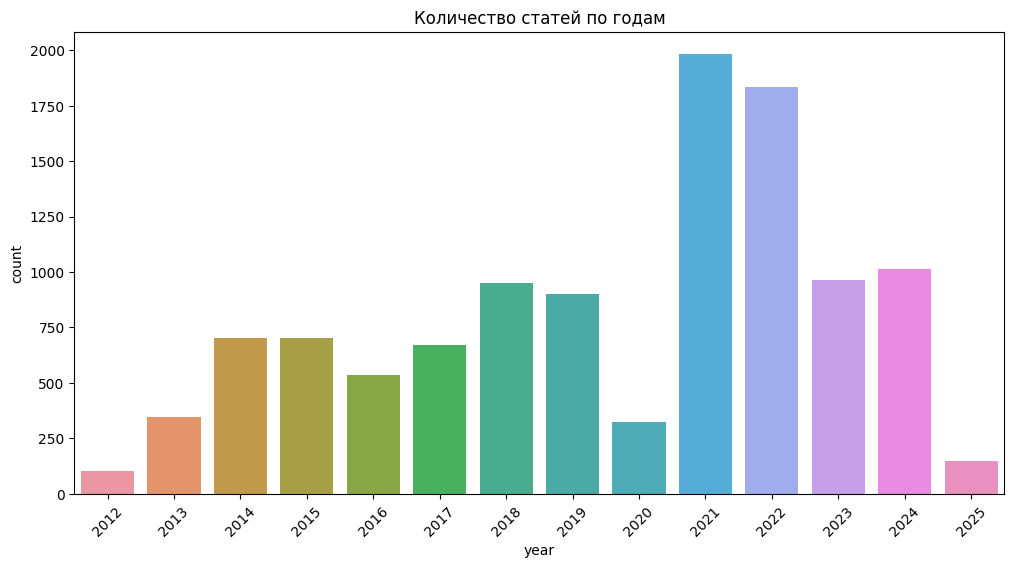

In [26]:
df2['published_time'] = pd.to_datetime(df2['published_time'], utc=True)

df2['year'] = df2['published_time'].dt.year
df2['month'] = df2['published_time'].dt.month
df2['day'] = df2['published_time'].dt.day
df2['day_of_week'] = df2['published_time'].dt.dayofweek
df2['hour'] = df2['published_time'].dt.hour

yearly_articles = df2['year'].value_counts().sort_index()
print(yearly_articles)

plt.figure(figsize=(12, 6))
sns.countplot(data=df2, x='year', order=sorted(df2['year'].unique()))
plt.title('Количество статей по годам')
plt.xticks(rotation=45)
plt.show()

       title_length  text_length
count         11181        11181
mean             61         4366
std              17         2728
min              16           68
25%              50         2208
50%              62         3592
75%              73         5827
max             107        13009


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


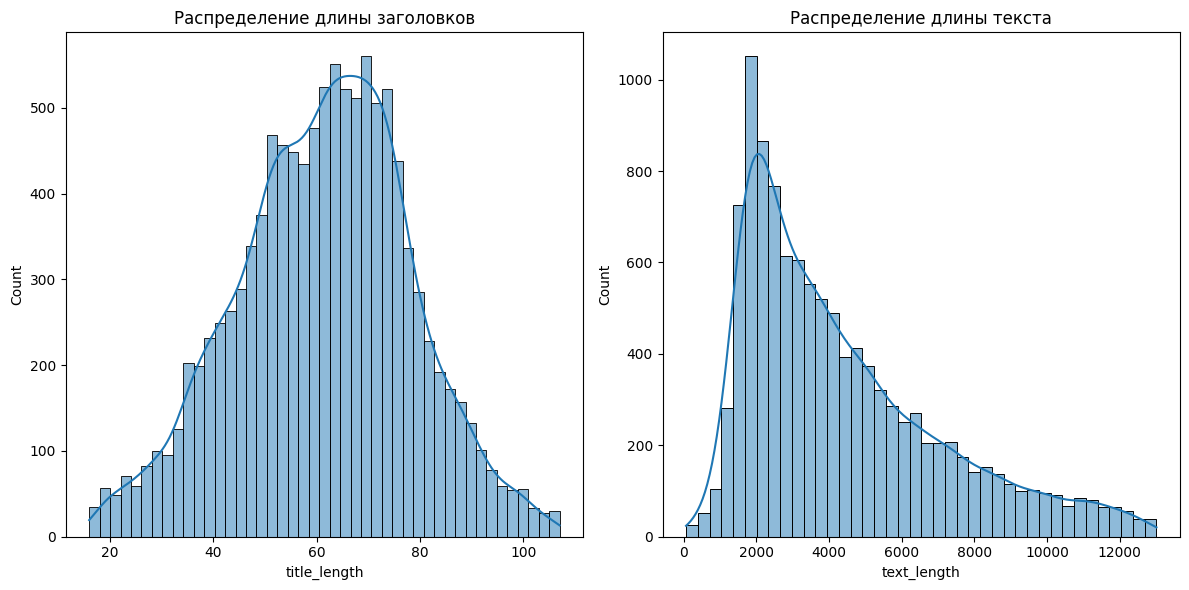

Самые популярные слова в заголовках:
[('bitcoin', 7679), ('the', 3173), ('and', 1674), ('for', 1527), ('with', 1028), ('blockchain', 684), ('new', 623), ('mining', 565), ('how', 512), ('crypto', 499), ('price', 415), ('lightning', 378), ('launches', 370), ('million', 340), ('will', 337), ('first', 317), ('from', 301), ('why', 300), ('are', 299), ('exchange', 294)]


In [27]:
df2['title_length'] = df2['title'].apply(len)
df2['text_length'] = df2['text'].apply(len)

print(df2[['title_length', 'text_length']].describe())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df2['title_length'], kde=True)
plt.title('Распределение длины заголовков')

plt.subplot(1, 2, 2)
sns.histplot(df2['text_length'], kde=True)
plt.title('Распределение длины текста')
plt.tight_layout()
plt.show()

from collections import Counter
import re

def get_top_words(text_series, n=20):
    all_text = ' '.join(text_series.astype(str))
    words = re.findall(r'\b[a-zA-Z]{3,}\b', all_text.lower())
    return Counter(words).most_common(n)

top_title_words = get_top_words(df2['title'], 20)
print("Самые популярные слова в заголовках:")
print(top_title_words)

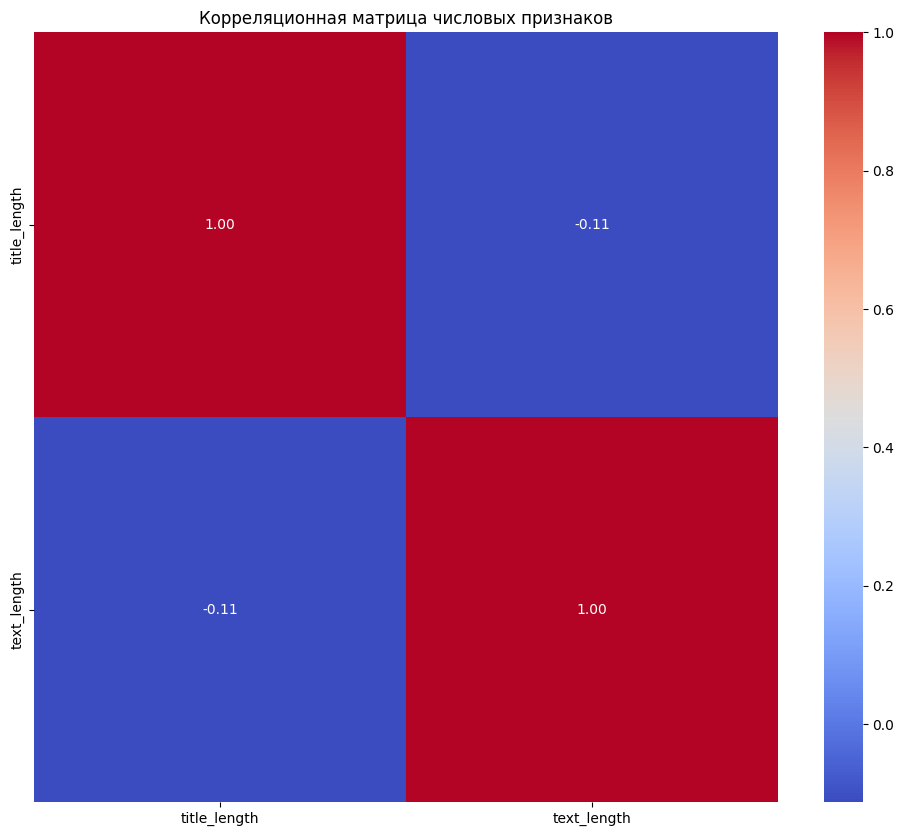

In [28]:
numeric_df = df2[['title_length', 'text_length']] #совсем бесполезный график(
correlation = numeric_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица числовых признаков')
plt.show()

<ipython-input-29-7f75e32ddec8>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df2['year_month'] = df2['published_time'].dt.to_period('M')


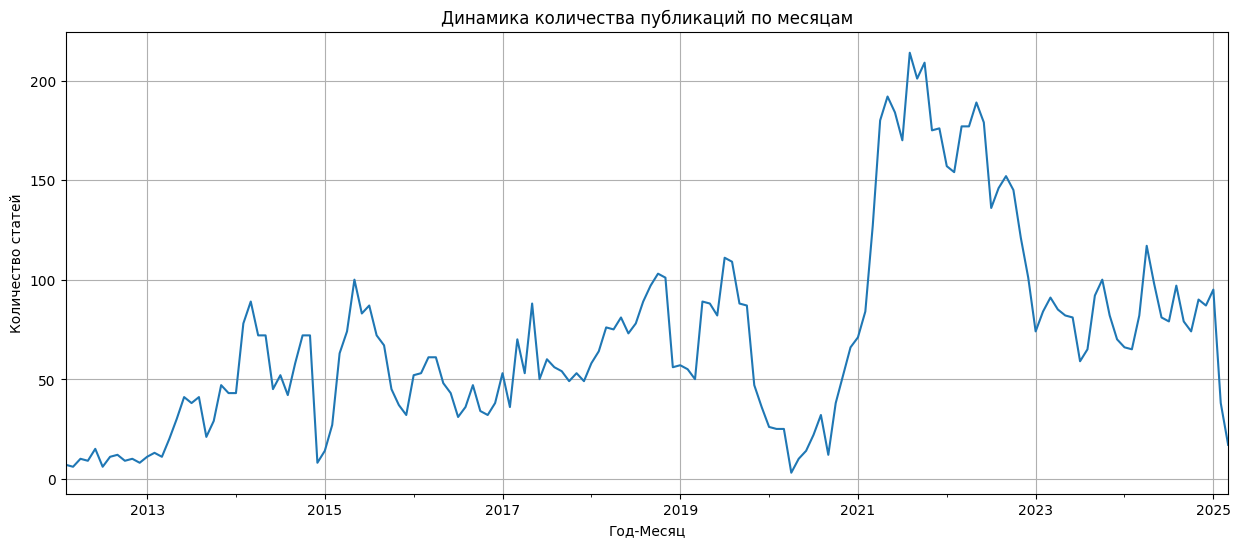

In [29]:
df2['year_month'] = df2['published_time'].dt.to_period('M')
monthly_articles = df2.groupby('year_month').size()

plt.figure(figsize=(15, 6))
monthly_articles.plot()
plt.title('Динамика количества публикаций по месяцам')
plt.xlabel('Год-Месяц')
plt.ylabel('Количество статей')
plt.grid(True)
plt.show()

In [30]:
df3.describe(include='all')

,date,time,content,datetime
count,106250,106250,106250,106250
unique,2125,10564,104490,NaN
top,2019-11-23,00:00:00,"In the last hour, 9 people won 1.00 BTC playin...",NaN
freq,50,94650,66,NaN
mean,NaN,NaN,NaN,2017-10-28 15:47:22.017468160
min,NaN,NaN,NaN,2014-09-18 00:00:00
25%,NaN,NaN,NaN,2016-03-02 00:00:00
50%,NaN,NaN,NaN,2017-08-15 00:00:00
75%,NaN,NaN,NaN,2019-01-28 00:00:00
max,NaN,NaN,NaN,2023-03-05 23:57:58


In [31]:
missing_values = df3.isnull().sum()
missing_percentage = (df3.isnull().sum() / len(df3)) * 100
missing_data = pd.concat([missing_values, missing_percentage], axis=1)
missing_data.columns = ['Missing Values', 'Percentage']
print(missing_data)

          Missing Values  Percentage
date                   0           0
time                   0           0
content                0           0
datetime               0           0


In [32]:
def check_data_validity(df):

    problems = {}
    
    problems['empty_text'] = (df['content'].str.len() <= 0).sum()
    
    try:
        if not pd.api.types.is_datetime64_any_dtype(df['datetime']):
            pd.to_datetime(df['datetime'])
        problems['invalid_dates'] = 0
    except Exception as e:
        problems['invalid_dates'] = f"Ошибка: {str(e)}"
    
    problems['duplicate_texts'] = df.duplicated(subset=['content']).sum()
    
    return problems


validity_issues = check_data_validity(df3)
print("Проблемы с валидностью данных:")
for issue, count in validity_issues.items():
    print(f"- {issue}: {count}")

l = len(df3)
print(f"Количество строк до удаления: {l}")

df3 = df3.drop_duplicates(subset=['content'], keep='first')

print(f"Количество строк после удаления: {len(df3)}")
print(f"Удалено строк: {l - len(df3)}")

Проблемы с валидностью данных:
- empty_text: 0
- invalid_dates: 0
- duplicate_texts: 1760
Количество строк до удаления: 106250
Количество строк после удаления: 104490
Удалено строк: 1760


In [33]:
if 'text_length' not in df3.columns:
    df3['text_length'] = df3['content'].apply(len)

columns_to_check = ['text_length']

for column in columns_to_check:
    Q1 = df3[column].quantile(0.25)
    Q3 = df3[column].quantile(0.75)
    IQR = Q3 - Q1
    
    theoretical_lower = Q1 - 1.5 * IQR
    theoretical_upper = Q3 + 1.5 * IQR
    
    lower_bound = max(20, theoretical_lower)
    
    
    upper_bound = theoretical_upper
    
    outliers = df3[(df3[column] < lower_bound) | (df3[column] > upper_bound)]
    outliers_count = len(outliers)
    outliers_percentage = (outliers_count / len(df3)) * 100
    
    print(f"\n--- Анализ выбросов для столбца '{column}' ---")
    print(f"Теоретическая нижняя граница: {theoretical_lower:.2f}")
    print(f"Скорректированная нижняя граница: {lower_bound:.2f}")
    print(f"Верхняя граница: {upper_bound:.2f}")
    print(f"Количество выбросов: {outliers_count} ({outliers_percentage:.2f}%)")
    
    if outliers_count > 0:
        print("\nПримеры выбросов:")       
        if column == 'text_length':
            print("\nСамые длинные тексты (первые 50 символов):")
            longest_texts = df3.nlargest(5, column)
            for idx, row in longest_texts.iterrows():
                print(f"{row['text_length']} символов: {row['content'][:50]}...")
            
            print("\nСамые короткие твиты:")
            shortest_texts = df3.nsmallest(5, column)
            for idx, row in shortest_texts.iterrows():
                print(f"{row['text_length']} символов: {row['content']}")
    
    if column == 'views':
        df3[f'{column}_capped'] = df3[column].clip(upper=upper_bound)
    elif column in ['title_length', 'text_length']:
        df3[f'{column}_is_outlier'] = ((df3[column] < lower_bound) | (df3[column] > upper_bound)).astype(int)

outlier_mask = np.zeros(len(df3), dtype=bool)
for column in columns_to_check:
    Q1 = df3[column].quantile(0.25)
    Q3 = df3[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    column_outliers = (df3[column] < lower_bound) | (df3[column] > upper_bound)
    outlier_mask = outlier_mask | column_outliers
l = len(df3)
df3 = df3[~outlier_mask]
print(f"\nОбщее количество строк без выбросов: {len(df3)} из {l} ({len(df3)/l*100:.2f}%)")


--- Анализ выбросов для столбца 'text_length' ---
Теоретическая нижняя граница: 9.50
Скорректированная нижняя граница: 20.00
Верхняя граница: 229.50
Количество выбросов: 11391 (10.90%)

Примеры выбросов:

Самые длинные тексты (первые 50 символов):
929 символов: @barbetta1 @sewpersists @Cruellaisdevine @BatmanRe...
886 символов: @Fujio0606 @itakethelead @sprague_paul @isamuuran1...
838 символов: @BillMew @BizBlockchainHQ @101Blockchains @alvinfo...
828 символов: @ImriSofer @RoBET_Coin @CoinMarketCap @officialmca...
762 символов: @JacktheOrigin @efebitcoin @Fuego_215 @stackysats ...

Самые короткие твиты:
1 символов: 👍
1 символов: 😂
1 символов: 🙏
1 символов: 🤣
1 символов: A

Общее количество строк без выбросов: 93376 из 104490 (89.36%)


year
2014     5238
2015    17894
2016    17981
2017    17511
2018    14381
2019    12308
2021     3641
2022     3953
2023      469
Name: count, dtype: int64


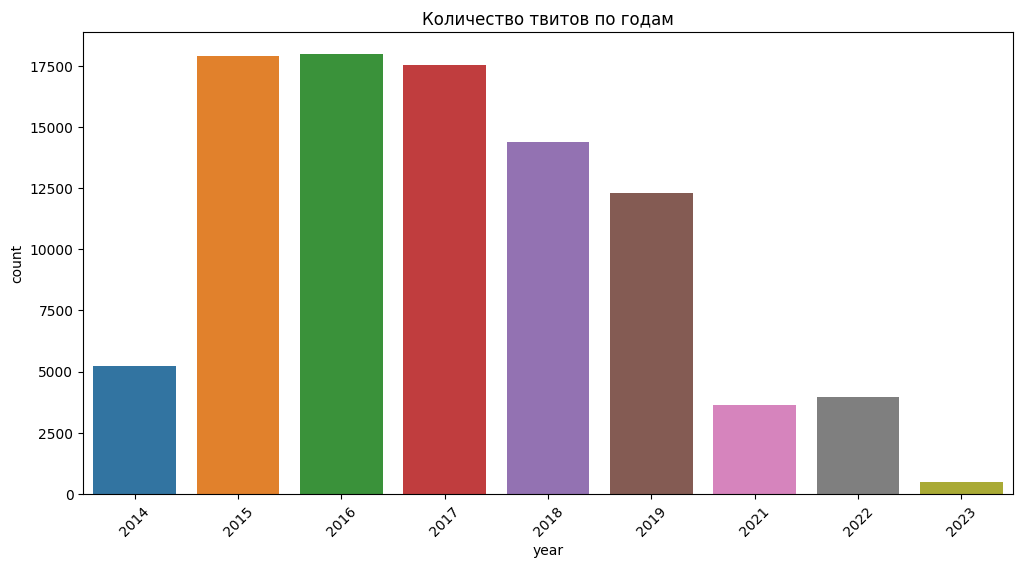

In [34]:
df3['datetime'] = pd.to_datetime(df3['datetime'], utc=True)

df3['year'] = df3['datetime'].dt.year
df3['month'] = df3['datetime'].dt.month
df3['day'] = df3['datetime'].dt.day
df3['day_of_week'] = df3['datetime'].dt.dayofweek
df3['hour'] = df3['datetime'].dt.hour

yearly_articles = df3['year'].value_counts().sort_index()
print(yearly_articles)

plt.figure(figsize=(12, 6))
sns.countplot(data=df3, x='year', order=sorted(df3['year'].unique()))
plt.title('Количество твитов по годам')
plt.xticks(rotation=45)
plt.show()

       text_length
count        93376
mean           117
std             41
min             10
25%             88
50%            124
75%            138
max            229


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


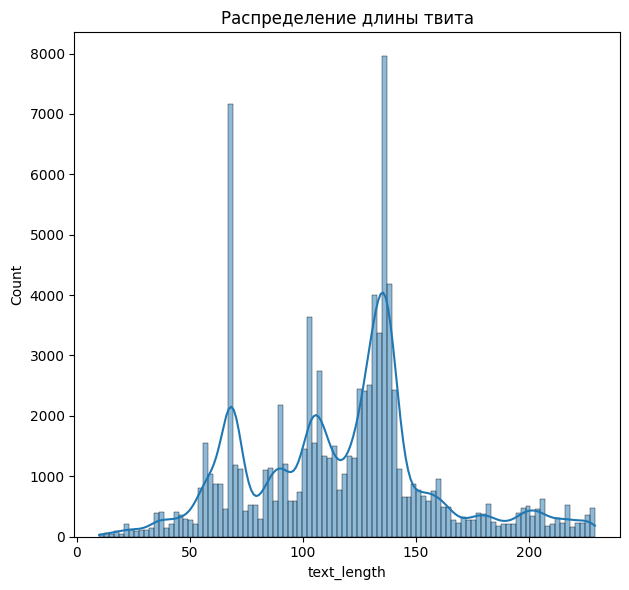

Самые популярные слова в твитах:
[('btc', 78009), ('bitcoin', 73849), ('price', 20190), ('com', 18432), ('https', 17502), ('http', 15466), ('the', 14321), ('twitter', 12656), ('buy', 10932), ('usd', 10892), ('and', 10516), ('bitstamp', 10417), ('pic', 9542), ('sell', 8827), ('eth', 8804), ('last', 8266), ('utc', 8080), ('current', 7902), ('www', 7238), ('btce', 7044)]


In [35]:
df3['text_length'] = df3['content'].apply(len)

print(df3[['text_length']].describe())

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 2)
sns.histplot(df3['text_length'], kde=True)
plt.title('Распределение длины твита')
plt.tight_layout()
plt.show()

from collections import Counter
import re

def get_top_words(text_series, n=20):
    all_text = ' '.join(text_series.astype(str))
    words = re.findall(r'\b[a-zA-Z]{3,}\b', all_text.lower())
    return Counter(words).most_common(n)

top_title_words = get_top_words(df3['content'], 20)
print("Самые популярные слова в твитах:")
print(top_title_words)

<ipython-input-36-2051c88fe604>:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df3['year_month'] = df3['datetime'].dt.to_period('M')


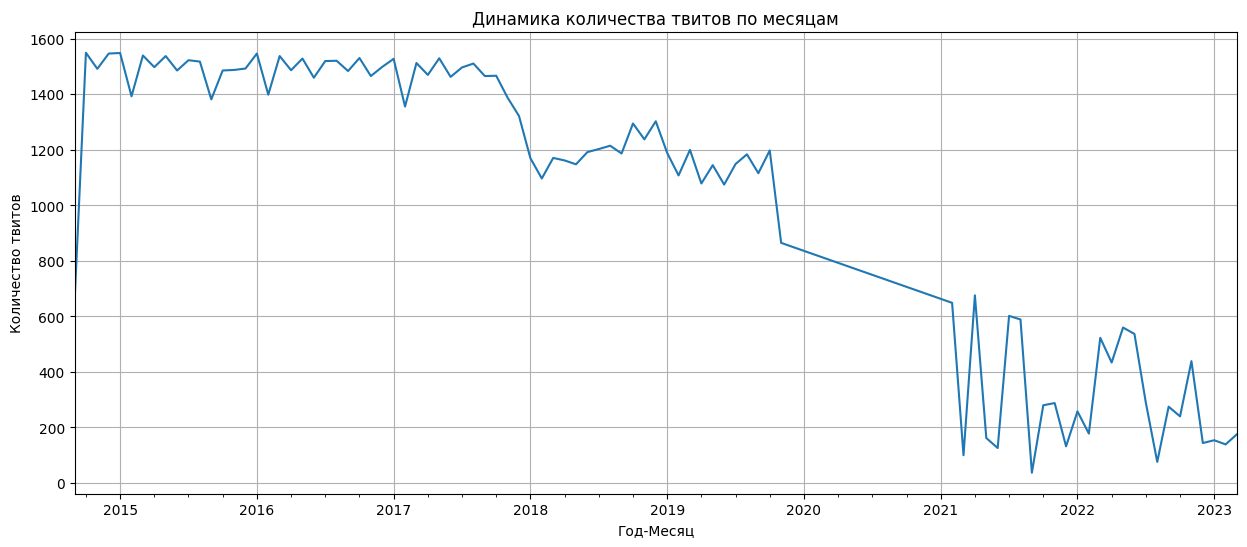

In [36]:
df3['year_month'] = df3['datetime'].dt.to_period('M')
monthly_articles = df3.groupby('year_month').size()

plt.figure(figsize=(15, 6))
monthly_articles.plot()
plt.title('Динамика количества твитов по месяцам')
plt.xlabel('Год-Месяц')
plt.ylabel('Количество твитов')
plt.grid(True)
plt.show()

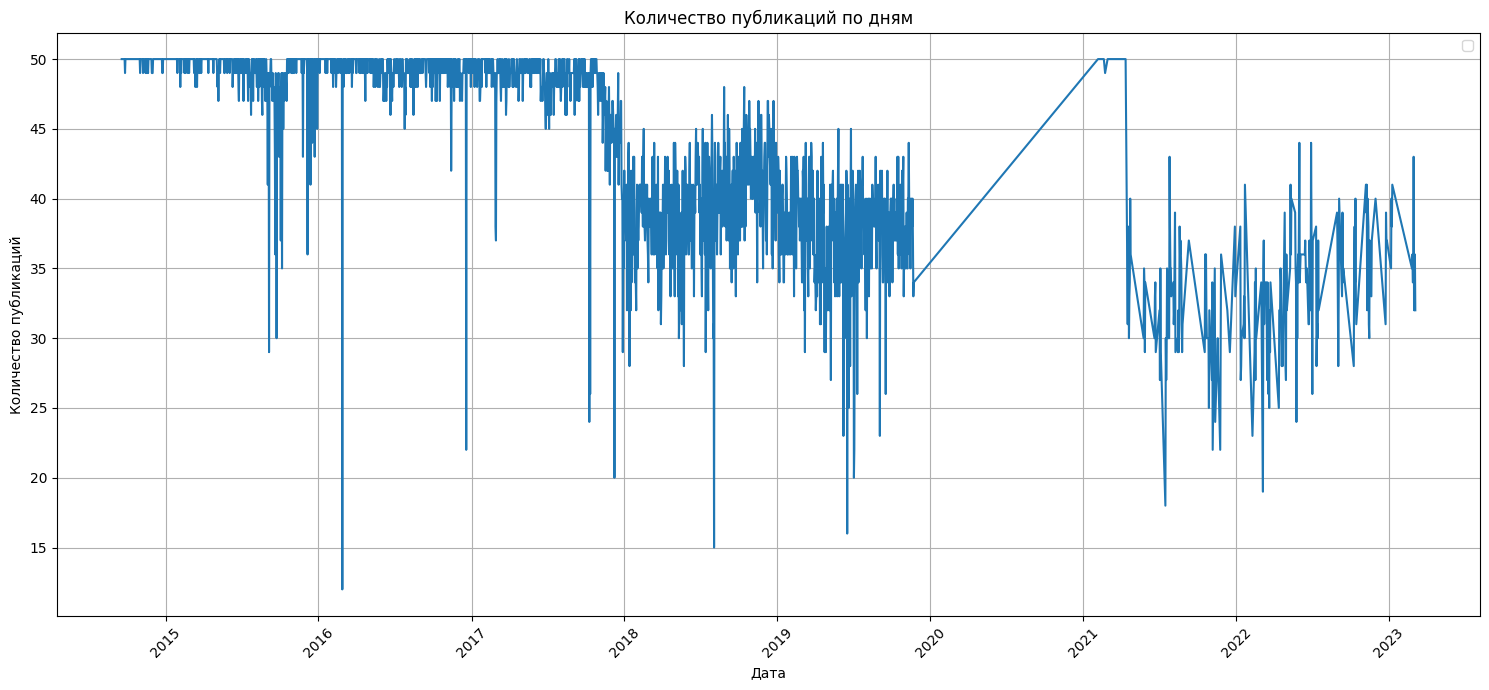

In [37]:
if not pd.api.types.is_datetime64_any_dtype(df3['datetime']):
    df3['datetime'] = pd.to_datetime(df3['datetime'])

df3['date'] = df3['datetime'].dt.date

publications_per_day = df3.groupby('date').size()

plt.figure(figsize=(15, 7))
plt.plot(publications_per_day.index, publications_per_day.values)
plt.title('Количество публикаций по дням')
plt.xlabel('Дата')
plt.ylabel('Количество публикаций')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend()
plt.show()

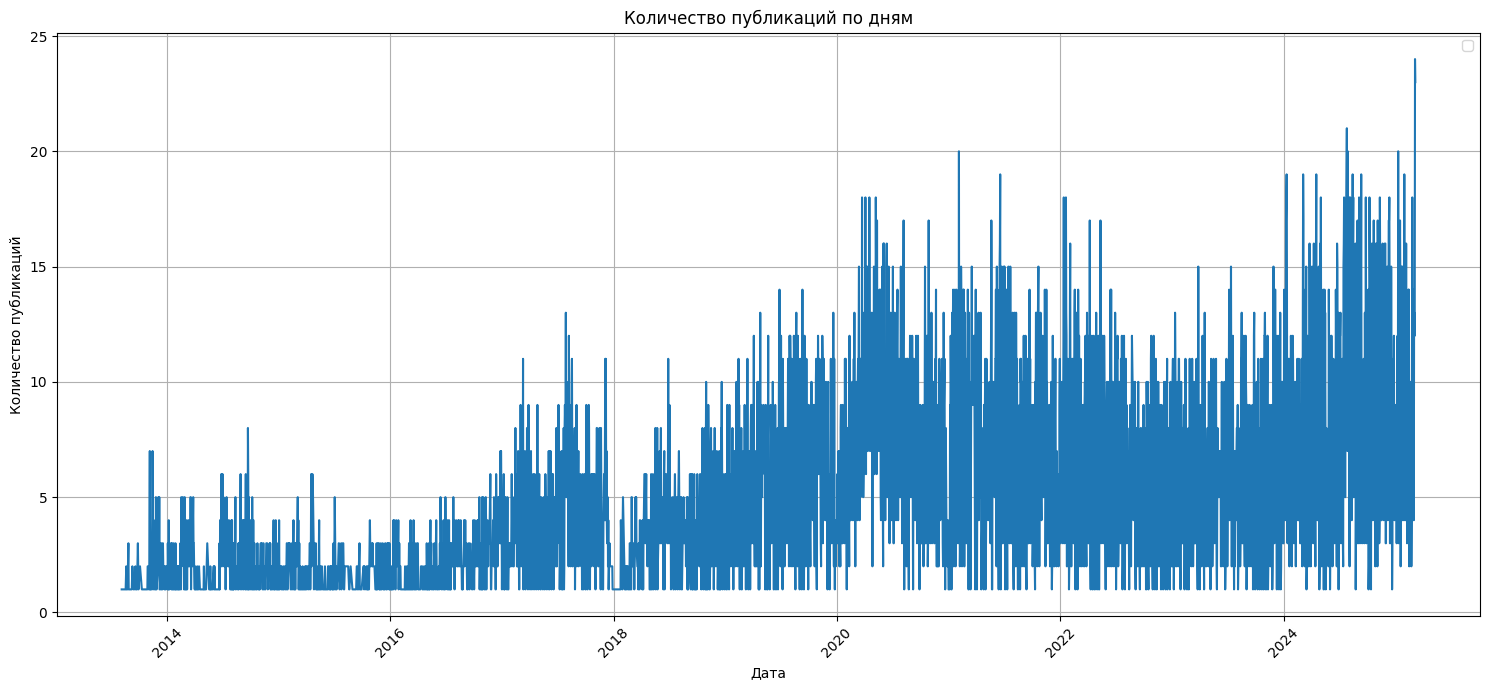

In [38]:
if not pd.api.types.is_datetime64_any_dtype(df1['published_time']):
    df1['published_time'] = pd.to_published_time(df1['published_time'])

df1['date'] = df1['published_time'].dt.date

publications_per_day = df1.groupby('date').size()

plt.figure(figsize=(15, 7))
plt.plot(publications_per_day.index, publications_per_day.values)
plt.title('Количество публикаций по дням')
plt.xlabel('Дата')
plt.ylabel('Количество публикаций')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend()
plt.show()

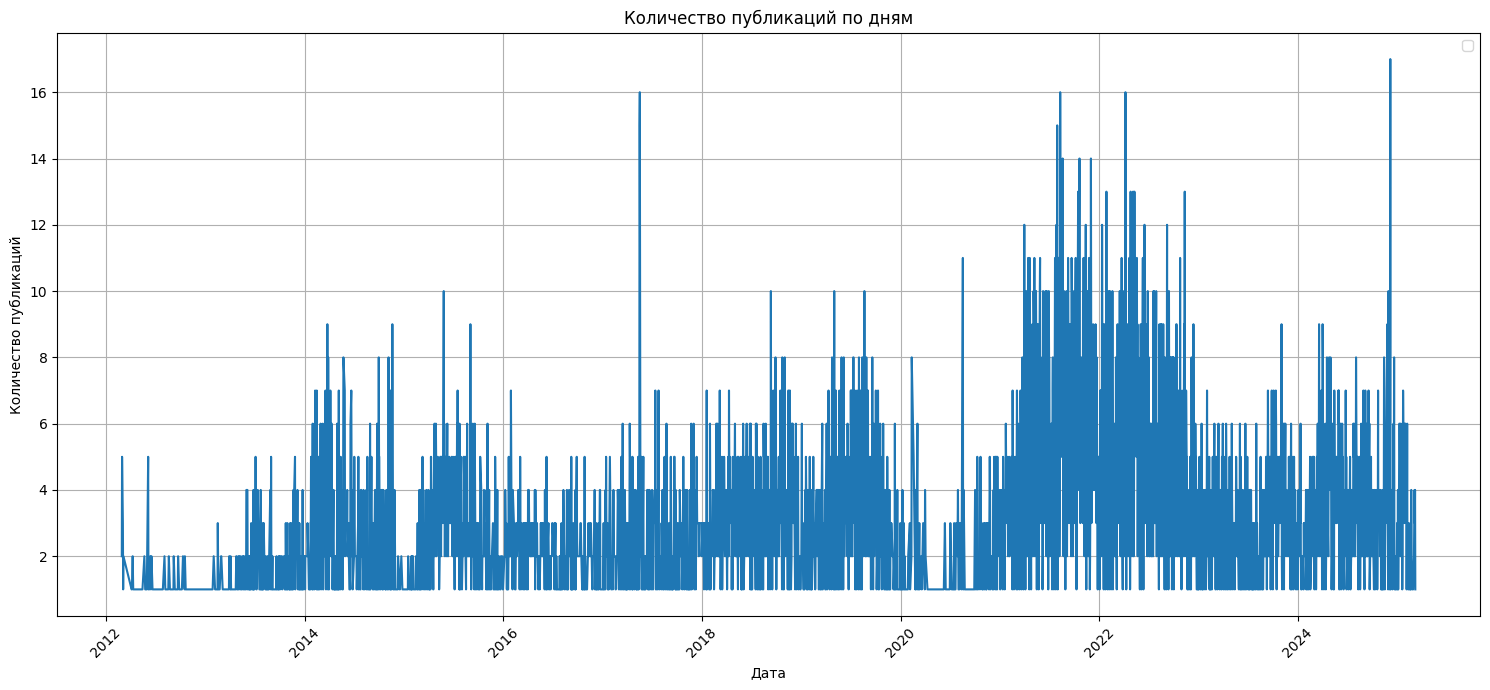

In [39]:
if not pd.api.types.is_datetime64_any_dtype(df2['published_time']):
    df2['published_time'] = pd.to_published_time(df2['published_time'])

df2['date'] = df2['published_time'].dt.date

publications_per_day = df2.groupby('date').size()

plt.figure(figsize=(15, 7))
plt.plot(publications_per_day.index, publications_per_day.values)
plt.title('Количество публикаций по дням')
plt.xlabel('Дата')
plt.ylabel('Количество публикаций')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend()
plt.show()

In [40]:
df1.to_csv('news1.csv')
df2.to_csv('news2.csv')
df3.to_csv('tweets.csv')

In [41]:
df1

,title,url,published_time,views,text,title_length,text_length,views_capped,title_length_is_outlier,text_length_is_outlier,year,month,day,day_of_week,hour,year_month,date
0,US will use stablecoins to ensure dollar hegem...,https://cointelegraph.com/news/us-stablecoins-...,2025-03-07 22:06:03+00:00,146,US will use stablecoins to ensure dollar hegem...,65,2677,146,0,0,2025,3,7,4,22,2025-03,2025-03-07
2,Darknet marketplace wallet with over $400M BTC...,https://cointelegraph.com/news/darknet-marketp...,2025-03-07 21:33:45+00:00,714,Darknet marketplace wallet with over $400M BTC...,68,2874,714,0,0,2025,3,7,4,21,2025-03,2025-03-07
3,"‘We’ve decided Bitcoin is scarce, it’s valuabl...",https://cointelegraph.com/news/bitcoin-scarce-...,2025-03-07 20:54:43+00:00,2166,"‘We’ve decided Bitcoin is scarce, it’s valuabl...",87,4368,2166,0,0,2025,3,7,4,20,2025-03,2025-03-07
4,Funding Bitcoin: Budget-neutral strategies for...,https://cointelegraph.com/news/assets-us-conve...,2025-03-07 19:59:31+00:00,2489,Funding Bitcoin: Budget-neutral strategies for...,64,2974,2489,0,0,2025,3,7,4,19,2025-03,2025-03-07
6,"US Bitcoin reserve ups volatility, futures recoil",https://cointelegraph.com/news/us-bitcoin-rese...,2025-03-07 18:47:21+00:00,2203,"US Bitcoin reserve ups volatility, futures rec...",49,3010,2203,0,0,2025,3,7,4,18,2025-03,2025-03-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27151,Germany is first to offer official opinion on ...,https://cointelegraph.com/news/germany_is_firs...,2013-08-20 09:15:00+00:00,346,Germany is first to offer official opinion on ...,53,1587,346,0,0,2013,8,20,1,9,2013-08,2013-08-20
27152,Bitcoin and internet gambling: A natural pairing,https://cointelegraph.com/news/bitcoin_and_int...,2013-08-18 12:40:00+00:00,362,Bitcoin and internet gambling: A natural pairi...,48,2494,362,0,0,2013,8,18,6,12,2013-08,2013-08-18
27153,"Android vulnerability to blame for $5,720 Bitc...",https://cointelegraph.com/news/android_vulnera...,2013-08-15 11:20:00+00:00,452,"Android vulnerability to blame for $5,720 Bitc...",55,1589,452,0,0,2013,8,15,3,11,2013-08,2013-08-15
27155,'Bitcoin is a currency': Federal judge says vi...,https://cointelegraph.com/news/bitcoin_is_a_cu...,2013-08-08 16:15:00+00:00,447,'Bitcoin is a currency': Federal judge says vi...,76,2996,447,0,0,2013,8,8,3,16,2013-08,2013-08-08


In [42]:
df2

,title,url,published_time,text,title_length,text_length,title_length_is_outlier,text_length_is_outlier,year,month,day,day_of_week,hour,year_month,date
0,White House Draws Line Between Bitcoin And Dig...,https://bitcoinmagazine.com/news/white-house-d...,2025-03-08 02:38:56+00:00,President Trump and his administration have ma...,91,6085,0,0,2025,3,8,5,2,2025-03,2025-03-08
1,"Not Your Keys, Not Your Content: Ownership In ...",https://bitcoinmagazine.com/technical/not-your...,2025-03-07 19:17:38+00:00,What does ownership mean in a truly digital ag...,59,5471,0,0,2025,3,7,4,19,2025-03,2025-03-07
2,The Clock Is Ticking While You Do Nothing,https://bitcoinmagazine.com/takes/the-clock-is...,2025-03-07 14:15:42+00:00,"Bitcoin doesn't exist in a vacuum, the real wo...",41,2801,0,0,2025,3,7,4,14,2025-03,2025-03-07
3,How Global Liquidity Fuels Bitcoin Price Growth,https://bitcoinmagazine.com/markets/global-liq...,2025-03-07 14:00:01+00:00,Bitcoin Price Performance Is Deeply Linked to ...,47,4102,0,0,2025,3,7,4,14,2025-03,2025-03-07
4,The United States Officially Establishes A Str...,https://bitcoinmagazine.com/news/the-united-st...,2025-03-07 02:49:12+00:00,President Trump has signed an executive order ...,68,3061,0,0,2025,3,7,4,2,2025-03,2025-03-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12264,Lightweight Bitcoin Clients/Wallets,https://bitcoinmagazine.com/reviews/lightweigh...,2012-02-29 07:59:35+00:00,Lightweight bitcoin clients differ mainly in t...,35,303,0,0,2012,2,29,2,7,2012-02,2012-02-29
12265,Client Side Secured Browser Wallets,https://bitcoinmagazine.com/technical/client-s...,2012-02-29 04:24:16+00:00,Client side browser wallets almost exactly res...,35,602,0,0,2012,2,29,2,4,2012-02,2012-02-29
12266,Bitcoin Exchange Wallets,https://bitcoinmagazine.com/technical/bitcoin-...,2012-02-29 03:46:22+00:00,"In a managed online wallet, everything is cont...",24,1038,0,0,2012,2,29,2,3,2012-02,2012-02-29
12267,Bitcoin Adoption Opportunity: Teenagers,https://bitcoinmagazine.com/culture/bitcoin-ad...,2012-02-28 16:34:40+00:00,If Bitcoin is to achieve mainstream success it...,39,1200,0,0,2012,2,28,1,16,2012-02,2012-02-28


In [43]:
df3

,date,time,content,datetime,text_length,text_length_is_outlier,year,month,day,day_of_week,hour,year_month
0,2022-11-30,10:52:24,🔥 New Algo detection: HTR/USDT 🔥\n\n🕛 11-30-20...,2022-11-30 10:52:24+00:00,176,0,2022,11,30,2,10,2022-11
1,2022-11-30,11:02:16,"""You do not sell your #bitcoin . ""\n-@saylor",2022-11-30 11:02:16+00:00,43,0,2022,11,30,2,11,2022-11
2,2022-11-30,10:52:44,Monolith buys #crypto every day...\n🌍,2022-11-30 10:52:44+00:00,36,0,2022,11,30,2,10,2022-11
4,2022-11-30,09:26:48,Sterling #SOLANA Wealthy #世界杯 pandora #USDC E...,2022-11-30 09:26:48+00:00,82,0,2022,11,30,2,9,2022-11
5,2022-11-30,09:30:00,#Crypto assets made a comeback to the #G20 age...,2022-11-30 09:30:00+00:00,169,0,2022,11,30,2,9,2022-11
...,...,...,...,...,...,...,...,...,...,...,...,...
106244,2019-11-23,00:00:00,Σε χαμηλό εξαμήνου υποχώρησε η τιμή του bitcoi...,2019-11-23 00:00:00+00:00,82,0,2019,11,23,5,0,2019-11
106245,2019-11-23,00:00:00,@coinhasyou Posted... \nhttps://t.co/viAS3KqEFE,2019-11-23 00:00:00+00:00,46,0,2019,11,23,5,0,2019-11
106246,2019-11-23,00:00:00,なぜ、今、ビットコインは上がらないのか？しかし、なぜ、私達は資産をビットコインで持たなければ...,2019-11-23 00:00:00+00:00,145,0,2019,11,23,5,0,2019-11
106247,2019-11-23,00:00:00,-=[ 605.047 ]=-\n\nTxs: 2.258\nSize: 1.26 MB\n...,2019-11-23 00:00:00+00:00,149,0,2019,11,23,5,0,2019-11


In [44]:
'''выводы: удалили совсем мусорные данные, 
а графики и прочее мало что значат, курс биткойна вообще ни от чего не зависит, 
тем более от длины текста в новости
более подробный анализ как в презе не понятно как делать,
у меня из данных только текста новостей.
эмбеддинги я извлек и сохранил pkl файлы, можно конечно их было проанализировать,
но вроде как это уже за пределами ТЗ из презы
'''

'выводы: удалили совсем мусорные данные, \nа графики и прочее мало что значат, курс биткойна вообще ни от чего не зависит, \nтем более от длины текста в новости\nболее подробный анализ как в презе не понятно как делать,\nу меня из данных только текста новостей.\nэмбеддинги я извлек и сохранил pkl файлы, можно конечно их было проанализировать,\nно вроде как это уже за пределами ТЗ из презы\n'